<h1>Отток клиентов<span class="tocSkip"></span></h1>
<h2>Содержание<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Цель-исследования" data-toc-modified-id="Цель-исследования-0.1">Цель исследования</a></span></li><li><span><a href="#Задачи-исследования" data-toc-modified-id="Задачи-исследования-0.2">Задачи исследования</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1">Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-1.1">Вывод по разделу</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2">Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1">Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.2">Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.3">Случайный лес</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.4">Вывод по разделу</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3">Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1">Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2">Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3">Случайный лес</a></span></li><li><span><a href="#Обобщение-метрик" data-toc-modified-id="Обобщение-метрик-3.4">Обобщение метрик</a></span></li><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-3.5">Вывод по разделу</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4">Тестирование модели</a></span></li><li><span><a href="#Вывод-по-проекту" data-toc-modified-id="Вывод-по-проекту-5">Вывод по проекту</a></span></li></ul></div>

### Цель исследования
Предсказать вероятность ухода клиента из банка.

### Задачи исследования
1. Исследовать данные, проанализировать целевой признак на предмет дисбаланса классов;
2. Разбить данные на три выборки, обучить несколько моделей классификации без учета и с учетом дисбаланса;
3. Выбрать модель с оптимальными гиперпараметрами и проверить метрику F1 на тестовой выборке;
4. Довести значение метрики F1 до 0.59 на тестовой выборке.



## Подготовка данных

In [1]:
!pip install imblearn -q

In [2]:
# Импортируем необходимые библиотеки и функции
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
plt.style.use('dark_background')
warnings.filterwarnings('ignore')


In [3]:
# Считываем данные и записываем в переменную
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('/content/Churn.csv')

In [4]:
# Смотрим на данные (выводим первые пять строк)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Мы видим, что в названиях столбцов использован так называемый CamelCase. Приведем названия к более привычному для нас «змеиному регистру».

In [5]:
df.columns = (df.columns.str.replace
 (r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
)
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В целом типы данных соответствуют значениям в столбцах. Изменим тип данных только у столбца `tenure`, т. к. в нем содержатся целочисленные значения.

In [7]:
df['tenure'] = df['tenure'].astype('Int64')

Посмотрим на данные на гистограммах.

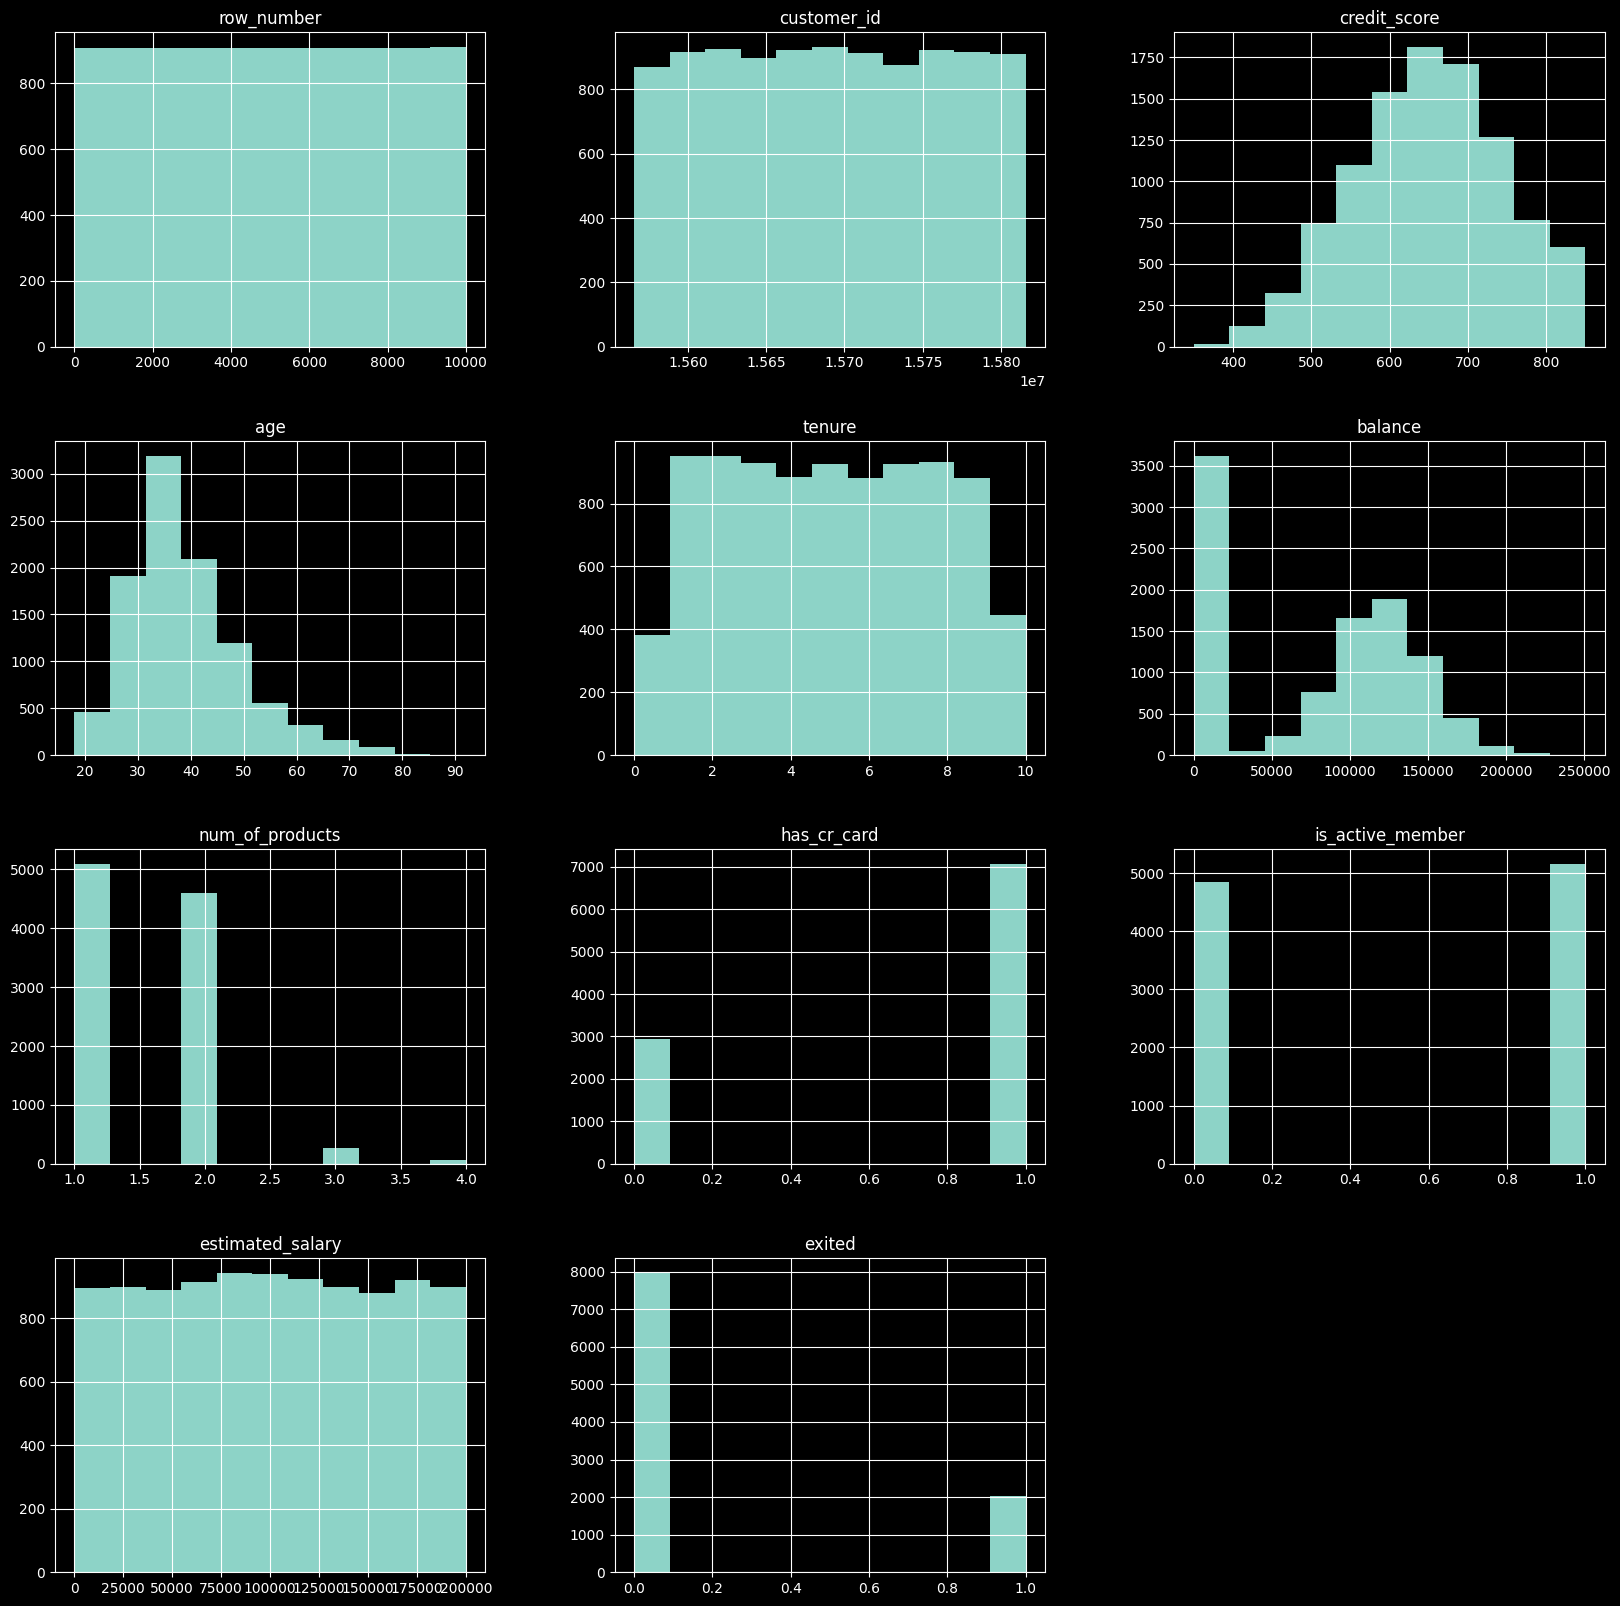

In [8]:
df.hist(figsize=(20,20), bins=11);

Проанализируем некоторые признаки по этим гистограммам. Признаки в столбцах `row_number` и `customer_id` не являются значимыми для предсказания, это просто порядковый номер и идентификатор клиента. 

В столбце `credit_score` распределение смещено вправо: клиентов с более высоким кредитным рейтингом у банка больше, чем с низким. Вероятно, этот параметр будет являться значимым для предсказания целевого признака.

В столбце `age` пик распределения значений приходится на возраст в диапазоне 30—40 лет — это самая активная платежеспособная часть населения, эти люди наиболее часто пользуются банковскими продуктами.

В столбце `tenure` (сколько лет человек является клиентом банка) распределение равномерное, но в крайних столбцах (0 и 10 лет) значений меньше. Можно предположить, что данные были собраны не в начале года, а в середине.

В столбце `balance` виден пик по количеству нулевых значений, то есть около трети клиентов из наших данных имеют нулевой баланс. Возможно, они не пользуются банковским счетом или открыли его для какой-то конкретной цели (например, погашение кредита или заключение сделки), а постоянно пользуются услугами другого банка. Среди остальных клиентов (не с нулевым балансом) распределение значений близко к нормальному.

В столбце `num_of_products` отражены данные о количестве продуктов, которыми пользуется клиент. Больше всего клиентов используют один банковский продукт, чуть меньше — два. Клиентов с тремя и четырьмя продуктами — небольшое количество. Других значений в столбце нет.

В столбце `has_cr_card` отражены данные о том, есть ли у клиента кредитная карта. Мы видим, что у 70% клиентов из нашей выборки имеется кредитная карта.

Данные в столбце `is_active_member` распределены равномерно — примерно одинаковое количество клиентов из нашей выборки имеют 0 и 1 по этому признаку.

Данные в столбце `estimated_salary` распределены равномерно.

Данные в столбце `exited` (целевой признак) несбалансированы — дисбаланс составляет примерно 8 к 2.

Посмотрим, есть ли в нашем датасете пропущенные значения.

In [9]:
df.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В наших данных есть пропущенные значения в столбце `tenure`.

Заполним эти данные медианой в зависимости от значения столбца `age` (поскольку разумно предположить, что клиенты более старшего возраста с большей вероятностью могут иметь более длительную историю взаимоотношений с банком).

In [10]:
for age in df['age'].unique():
    df.loc[(df['age'] == age) & (df['tenure'].isna()), 'tenure'] = (
        df.loc[df['age'] == age, 'tenure'].median().round()
    )
    
# Смотрим на результат
df.tenure.value_counts(dropna=False)

5       1764
1        953
2        950
8        933
3        933
4        926
7        925
6        906
9        882
10       446
0        382
<NA>       0
Name: tenure, dtype: Int64

In [11]:
# Смотрим, есть ли дубликаты в данных
df.duplicated().any()

False

Посмотрим, изменилось ли распределение целевого признака после преобразования.

In [12]:
df.exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Распределение не изменилось.

Данные в столбцах `row_number`, `customer_id` и `surname` не влияют на предсказание, т. к. они представляют собой идентификаторы конкретных пользователей, а не их обобщенные признаки. Удалим эти столбцы.

In [13]:
df.drop(['surname', 'customer_id', 'row_number'], axis=1, inplace=True)
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

### Вывод по разделу
Мы провели обзор и предварительную подготовку данных:
1. В датасете 10 000 наблюдений.
2. Изменили тип данных в столбце `tenure`.
3. Удалили переменные, которые не оказывают влияния на качество модели, поскольку не являются обобщающими признаками, а служат для идентификации пользователей (это столбцы `surname`, `customer_id` и `row_number`).
4. Заполнили пропуски в столбце `tenure` медианным значением в зависимости от возраста клиента.
5. В классах в столбце с целевым признаком имеется дисбаланс (примерно 8 к 2). 

## Исследование задачи

В данном исследовании мы будем решать задачу бинарной классификации — предсказывать значение 0 (клиент не уйдет) и 1 (клиент уйдет) на основе имеющихся данных. Для этого мы будем использовать модели логистической регрессии, решающего дерева и случайного леса. Оценку качества оптимальной модели будем производить при помощи метрики F1.

Еще раз посмотрим на дисбаланс классов в целевом признаке.

In [14]:
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

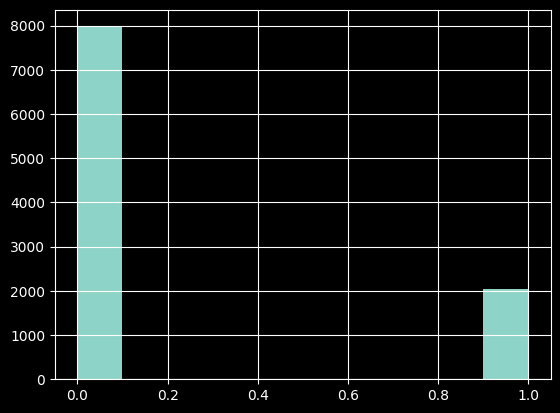

In [15]:
df['exited'].hist();

Для начала попробуем обучить и использовать модели без учета дисбаланса. Разобьем данные на нецелевые и целевой признаки.

In [16]:
features = df.drop(['exited'], axis=1)
target = df['exited']

Посмотрим, есть ли в наших данных признаки, которые сильно коррелируют между собой.

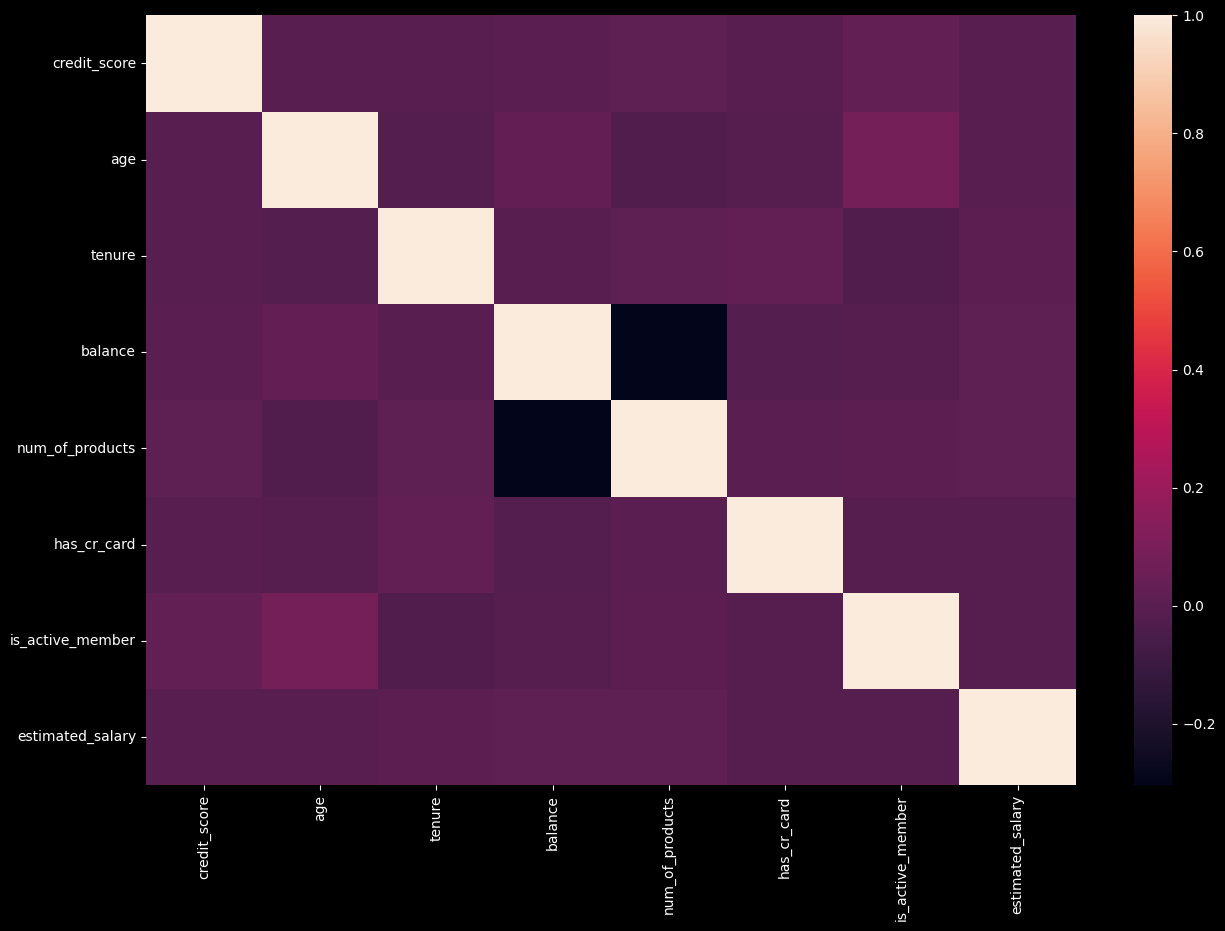

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(features.corr());

Как видим, сильной корреляции между независимыми переменными, которая указывала бы на наличие мультиколлинеарности, не наблюдается. 

Объявим базовые функции и переменные для списков, куда будем сохранять метрики моделей.

In [18]:
# Делаем функцию для расчета метрики auc-roc
def auc_roc(features, target, model):
    prob = model.predict_proba(features)
    prob_one = prob[:,1]
    auc_roc = roc_auc_score(target, prob_one)
    return auc_roc


In [19]:
# Строим ROC-кривую
def make_roc_curve(features, target, model):
    prob = model.predict_proba(features)
    prob_one = prob[:,1]
    fpr, tpr, thresholds = roc_curve(target, prob_one)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0,1], [0,1], linestyle = '--')
    plt.show()

In [20]:
model_list = []
auc_roc_list = []
f1_list = []

### Логистическая регрессия

Посмотрим, какие категориальные признаки у нас остались.

In [21]:
features.dtypes

credit_score          int64
geography            object
gender               object
age                   int64
tenure                Int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
dtype: object

Остались строковые значения в столбцах `geography` и `gender`. Для модели логистической регрессии преобразуем эти признаки техникой OHE после разбиения на обучающую, валидационную и тестовую выборки. 

Разобьем данные на три выборки — обучающую, валидационную и тестовую в соотношении 60:20:20.

In [22]:
features_train, features_temp, target_train, target_temp = (train_test_split(
    features, target, test_size=0.4, random_state=3337) 
                                                           )
features_valid, features_test, target_valid, target_test = (train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=3337)
                                                           )


In [23]:
# Преобразовываем категориальные данные техникой OHE (get_dummies)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

Посмотрим на масштаб наших признаков.

In [24]:
features_train_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6629,579,39,5,0.00,2,0,1,39891.84,0,0,1
2900,626,26,5,148610.41,3,0,1,104502.02,0,1,0
5047,471,26,8,0.00,2,1,1,179655.87,0,1,1
2547,682,59,0,122661.39,1,0,1,84803.76,0,1,0
6659,668,39,4,79896.00,1,1,0,38466.39,1,0,1


Поскольку масштаб различается, проведем масштабирование (стандартизацию) для приведения значений к одной шкале. Будем использовать StandardScaler. Масштабированные признаки будем использовать для модели регрессии.

In [25]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric]) 
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric]) 
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) 
features_train_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6629,-0.747044,0.012235,0.001147,-1.232107,0.816999,0,1,-1.055967,0,0,1
2900,-0.260086,-1.230336,0.001147,1.159633,2.535189,0,1,0.071028,0,1,0
5047,-1.866012,-1.230336,1.087660,-1.232107,0.816999,1,1,1.381937,0,1,1
2547,0.320120,1.923881,-1.809708,0.742009,-0.901191,0,1,-0.272568,0,1,0
6659,0.175068,0.012235,-0.361024,0.053741,-0.901191,1,0,-1.080831,1,0,1


Обучим модель логистической регрессии на наших данных без учета дисбаланса классов в целевом признаке.

In [26]:
model_lr=LogisticRegression(random_state=3337, solver='liblinear')

model_lr.fit(features_train_ohe, target_train)

predicted_train=model_lr.predict(features_train_ohe)
predicted_valid=model_lr.predict(features_valid_ohe)

f1_train=f1_score(target_train, predicted_train)
f1_valid=f1_score(target_valid, predicted_valid)

print(f'F1 на обучающей выборке: {f1_train}')
print(f'F1 на валидационной выборке: {f1_valid}')


F1 на обучающей выборке: 0.3225044300059066
F1 на валидационной выборке: 0.3229357798165138


In [27]:
# Добавляем метрику f1 и название модели в список
model_list.append('Logistic Regression Unbalanced')
f1_list.append(f1_valid)

Метрика F1 низкая (менее 0.5). Рассчитаем метрику AUC-ROC и построим ROC-кривую.

In [28]:
auc_roc_lr_unbalanced = auc_roc(features_valid_ohe, target_valid, model_lr)
auc_roc_lr_unbalanced

0.7603039995954258

In [29]:
auc_roc_list.append(auc_roc_lr_unbalanced)

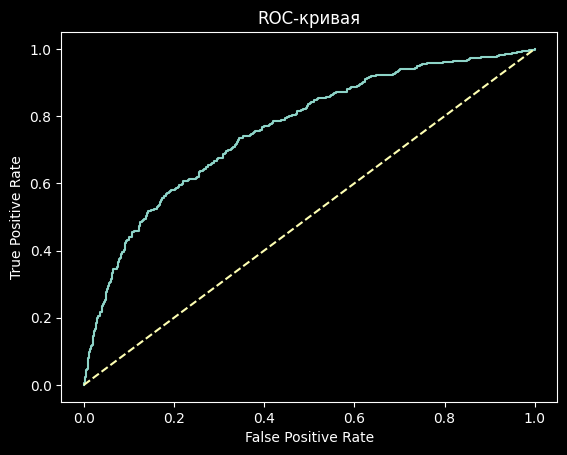

In [30]:
make_roc_curve(features_valid_ohe, target_valid, model_lr)

### Решающее дерево

Закодируем признаки для дерева при помощи метода OrdinalEncoder.

In [31]:
encoder = OrdinalEncoder()
encoder.fit(features_train)
features_train_ordinal = pd.DataFrame(encoder.transform(features_train),
                                     columns=features_train.columns)
encoder.fit(features_valid)
features_valid_ordinal = pd.DataFrame(encoder.transform(features_valid),
                                     columns=features_valid.columns)
encoder.fit(features_test)
features_test_ordinal = pd.DataFrame(encoder.transform(features_test),
                                     columns=features_test.columns)


Обучим модель решающего дерева. Подберем оптимальные гиперпараметры в цикле (переберем параметр max_depth и оценим качество метрикой F1 на валидационной выборке).

In [32]:
best_model_dt = None
best_depth_dt = 0
best_f1_train_dt = 0 
best_f1_valid_dt = 0 

f1_train_list_dt = []
f1_valid_list_dt = []

for depth in tqdm(range(1, 60, 1)):
    model_dt = DecisionTreeClassifier(random_state=3337, max_depth=depth)
    model_dt.fit(features_train_ordinal, target_train)
    predicted_train_dt = model_dt.predict(features_train_ordinal)
    f1_train_dt = f1_score(target_train, predicted_train_dt)
    predicted_valid_dt = model_dt.predict(features_valid_ordinal)
    f1_valid_dt = f1_score(target_valid, predicted_valid_dt)
    f1_train_list_dt.append(f1_train_dt)
    f1_valid_list_dt.append(f1_valid_dt)
    if f1_valid_dt > best_f1_valid_dt:
        best_f1_train_dt = f1_train_dt
        best_f1_valid_dt = f1_valid_dt
        best_depth_dt = depth
        best_model_dt = model_dt
print('')        
print(f'F1 лучшей модели DT на обучающей выборке: {best_f1_train_dt}, глубина: {best_depth_dt}')
print(f'F1 лучшей модели DT на валидационной выборке: {best_f1_valid_dt}')
    

100%|██████████| 59/59 [00:03<00:00, 18.77it/s]


F1 лучшей модели DT на обучающей выборке: 0.5292887029288703, глубина: 4
F1 лучшей модели DT на валидационной выборке: 0.5331230283911673


In [33]:
model_list.append('Decision Tree Unbalanced')
f1_list.append(best_f1_valid_dt)

Посмотрим на графике, как менялась метрика F1 в зависимости от глубины дерева, на обучающей и валидационной выборках.

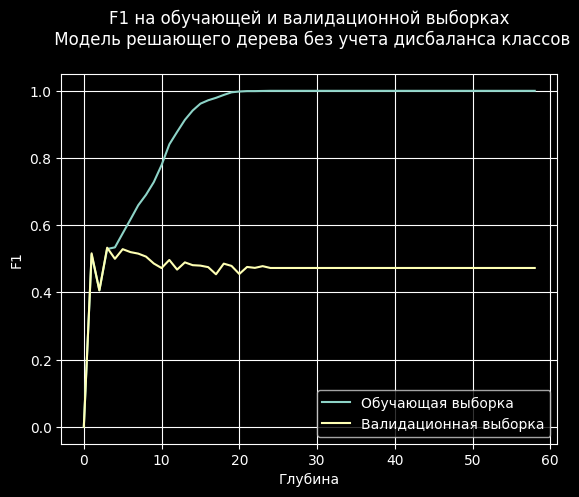

In [34]:
plt.figure()
plt.plot(figsize=(10,6))
plt.xlim=([0.0, 1.0])
plt.plot(f1_train_list_dt, label='Обучающая выборка')
plt.plot(f1_valid_list_dt, label='Валидационная выборка')
plt.xlabel('Глубина')
plt.ylabel('F1')
plt.title('F1 на обучающей и валидационной выборках\n Модель решающего дерева без учета дисбаланса классов\n')
plt.grid(True)
plt.legend();


Построим ROC-кривую и рассчитаем метрику AUC-ROC для этой модели.

In [35]:
auc_roc_dt_unbalanced = auc_roc(features_valid_ordinal, target_valid, model_dt)
auc_roc_dt_unbalanced

0.672958638607759

In [36]:
auc_roc_list.append(auc_roc_dt_unbalanced)

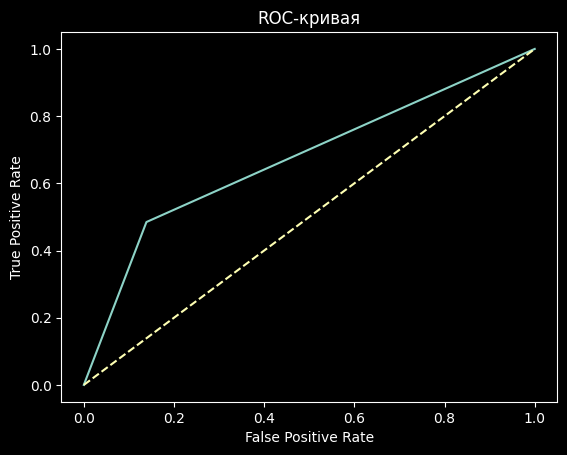

In [37]:
make_roc_curve(features_valid_ordinal, target_valid, model_dt)

Метрики далеки от целевых.

### Случайный лес

Обучим модель случайного леса. Подберем оптимальные гиперпараметры в цикле (переберем параметры max_depth и n_estimators и оценим качество метрикой F1 на валидационной выборке).

In [38]:
%%time
best_model_rf = None
best_depth_rf = 0
best_est_rf = 0
best_f1_train_rf = 0 
best_f1_valid_rf = 0 

f1_train_list_rf = []
f1_valid_list_rf = []

for depth in tqdm(range(2, 30, 2)):
    for est in range(2, 60, 2):
        model_rf = RandomForestClassifier(random_state=3337, max_depth=depth, n_estimators=est)
        model_rf.fit(features_train_ordinal, target_train)
        predicted_train_rf = model_rf.predict(features_train_ordinal)
        f1_train_rf = f1_score(target_train, predicted_train_rf)
        predicted_valid_rf = model_rf.predict(features_valid_ordinal)
        f1_valid_rf = f1_score(target_valid, predicted_valid_rf)
        f1_train_list_rf.append(f1_train_rf)
        f1_valid_list_rf.append(f1_valid_rf)
        if f1_valid_rf > best_f1_valid_rf:
            best_f1_train_rf = f1_train_rf
            best_f1_valid_rf = f1_valid_rf
            best_depth_rf = depth
            best_est_rf = est
            best_model_rf = model_rf
print('')            
print(f'F1 лучшей модели RF на обучающей выборке: {best_f1_train_rf}, глубина: {best_depth_rf}, деревьев: {best_est_rf}')
print(f'F1 лучшей модели RF на валидационной выборке: {best_f1_valid_rf}')
    

100%|██████████| 14/14 [02:25<00:00, 10.38s/it]


F1 лучшей модели RF на обучающей выборке: 0.8265162200282088, глубина: 12, деревьев: 30
F1 лучшей модели RF на валидационной выборке: 0.5254515599343186
CPU times: user 2min 11s, sys: 380 ms, total: 2min 12s
Wall time: 2min 25s


In [39]:
model_list.append('Random Forest Unbalanced')
f1_list.append(best_f1_valid_rf)

Метрика F1 на валидационной выборке пока далека от целевой.

Построим ROC-кривую и рассчитаем метрику AUC-ROC для этой модели.

In [40]:
auc_roc_rf_unbalanced = auc_roc(features_valid_ordinal, target_valid, model_rf)
auc_roc_rf_unbalanced 

0.8159937986358263

In [41]:
auc_roc_list.append(auc_roc_rf_unbalanced)

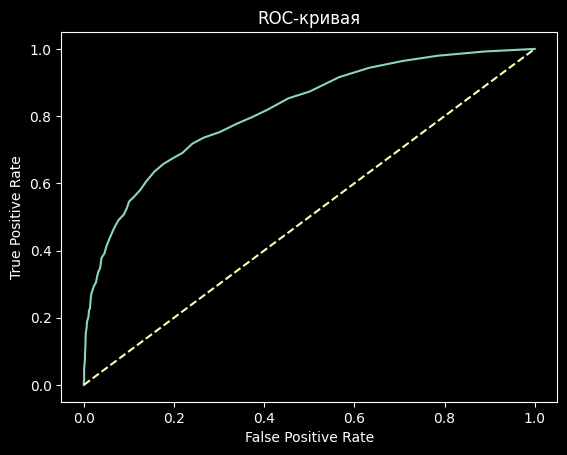

In [42]:
make_roc_curve(features_valid_ordinal, target_valid, model_rf)

### Вывод по разделу

Мы разбили выборку на тренировочную, валидационную и тестовую в пропорции 60:20:20.

После этого при помощи метода OHE были преобразованы оставшиеся категориальные значения (колонки `geography` и `gender`) для модели логистической регрессии. Для моделей дерева и леса категориальные признаки мы преобразовали при помощи OrdinalEncoder.

При помощи StandardScaler была проведена стандартизация признаков для приведения значений к единой шкале.

Мы обучили три модели для решения задачи классификации (логистическая регрессия, решающее дерево, случайный лес). На этом этапе дисбаланс целевого признака мы не учитывали.

Наименьшее значение метрики F1 на валидационной выборке — у модели логистической регрессии. Наибольшее — у модели решающего дерева.

Поскольку в целевом признаке классы не сбалансированы, а для оценки моделей мы используем F1-меру, далее мы будем учитывать эту несбалансированность при обучении моделей.

## Работа с дисбалансом

### Логистическая регрессия

Обучим модель логистической регрессии с учетом «веса» классов — более редкому классу (1) придается больший вес.

In [43]:
model_lr=LogisticRegression(random_state=3337, solver='liblinear', 
                            class_weight='balanced')
model_lr.fit(features_train_ohe, target_train)
predicted_train=model_lr.predict(features_train_ohe)
predicted_valid=model_lr.predict(features_valid_ohe)
f1_train=f1_score(target_train, predicted_train)
f1_valid=f1_score(target_valid, predicted_valid)
print(f'F1 на обучающей выборке: {f1_train}')
print(f'F1 на валидационной выборке: {f1_valid}')

F1 на обучающей выборке: 0.497243980272701
F1 на валидационной выборке: 0.47758620689655173


Мы видим, что метрика F1 немного повысилась по сравнению с моделью, обученной на несбалансированных данных, но она все еще далека от нашего целевого значения.

In [44]:
auc_roc_balanced = auc_roc(features_valid_ohe, target_valid, model_lr)
auc_roc_balanced

0.7652094619795058

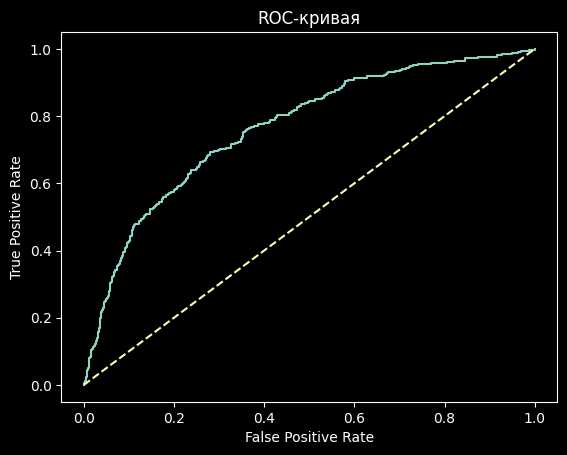

In [45]:
make_roc_curve(features_valid_ohe, target_valid, model_lr)

Попробуем использовать другие способы устранения дисбаланса. Увеличим размеры малого класса (1).

In [46]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=3337)
    target_upsampled = shuffle(target_upsampled, random_state=3337)
    
    return features_upsampled, target_upsampled



In [47]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 4)

In [48]:
model_lr = LogisticRegression(random_state=3337, solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled)
predicted_valid_lr = model_lr.predict(features_valid_ohe)# < напишите код здесь >

print(f1_score(target_valid, predicted_valid_lr))

0.4691983122362869


Метрика на этих данных понизилась. Применим другой способ борьбы с дисбалансом — уменьшение размера более многочисленного класса (0).

In [49]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


In [50]:
features_downsampled, target_downsampled = downsample(features_train_ohe, target_train, 0.2)

In [51]:
model_lr = LogisticRegression(random_state=3337, solver='liblinear')
model_lr.fit(features_downsampled, target_downsampled)
predicted_valid_lr = model_lr.predict(features_valid_ohe)# < напишите код здесь >

print(f1_score(target_valid, predicted_valid_lr))

0.4548736462093863


Метрика на этих данных понизилась. Добавим в таблицу лучшую метрику.

In [52]:
f1_list.append(f1_valid)
model_list.append('Logistic Regression Balanced')

In [53]:
auc_roc_list.append(auc_roc_balanced)

### Решающее дерево

Для моделей дерева и леса мы будем использовать функцию SMOTE для устранения дисбаланса. Далее мы будем подбирать гиперпараметры через RandomizedSearchCV, поэтому сразу объединим тренировочную и валидационную выборки.

In [54]:
features_val_train = pd.concat([features_train, features_valid])
target_val_train = pd.concat([target_train, target_valid])

In [55]:
# Проеобразуем категориальные признаки
encoder = OrdinalEncoder()
encoder.fit(features_val_train)
features_train_ordinal = pd.DataFrame(encoder.transform(features_val_train),
                                     columns=features_val_train.columns)
encoder.fit(features_test)
features_test_ordinal = pd.DataFrame(encoder.transform(features_test),
                                     columns=features_test.columns)


In [56]:
sm = SMOTE(random_state=3337, k_neighbors=5)
features_sm, target_sm = sm.fit_resample(features_train_ordinal, target_val_train)

In [57]:
%%time
model_dt=DecisionTreeClassifier(random_state=3337)
# Задаем диапазоны параметров
params = {'max_depth': range (2, 100, 1),
          'min_samples_leaf': range (2, 20),
          'min_samples_split': range (2, 10, 2)}
rs_dt = RandomizedSearchCV(model_dt, params, cv=5, scoring='f1', random_state=3337)
rs_dt.fit(features_sm, target_sm)

CPU times: user 3.11 s, sys: 9.04 ms, total: 3.12 s
Wall time: 3.12 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3337),
                   param_distributions={'max_depth': range(2, 100),
                                        'min_samples_leaf': range(2, 20),
                                        'min_samples_split': range(2, 10, 2)},
                   random_state=3337, scoring='f1')

In [58]:
print(f'Лучшие параметры модели DT: {rs_dt.best_params_}')

Лучшие параметры модели DT: {'min_samples_split': 8, 'min_samples_leaf': 17, 'max_depth': 18}


In [59]:
print(f'F1 модели DT: {rs_dt.best_score_}')

F1 модели DT: 0.8478919714176965


In [60]:
model_list.append('Decision Tree Balanced')
f1_list.append(rs_dt.best_score_)

In [61]:
auc_roc_dt = auc_roc(features_sm, target_sm, rs_dt)
auc_roc_dt

0.9744866228448751

In [62]:
auc_roc_list.append(auc_roc_dt)

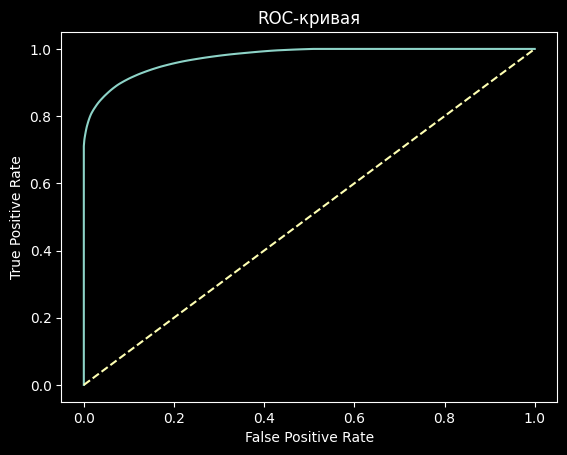

In [63]:
make_roc_curve(features_sm, target_sm, rs_dt)

Мы видим увеличение метрик по сравнению с несбалансированной моделью.

### Случайный лес

In [64]:
%%time
model_rf=RandomForestClassifier(random_state=3337)
# Задаем диапазоны параметров
params = {'max_depth': range (2, 100, 1),
          'n_estimators': range (2, 150, 1),
          'min_samples_leaf': range (2, 20),
          'min_samples_split': range (2, 30, 2)}
rs_rf = RandomizedSearchCV(model_rf, params, cv=5, scoring='f1', random_state=3337)
rs_rf.fit(features_sm, target_sm)

CPU times: user 56 s, sys: 130 ms, total: 56.2 s
Wall time: 56.3 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3337),
                   param_distributions={'max_depth': range(2, 100),
                                        'min_samples_leaf': range(2, 20),
                                        'min_samples_split': range(2, 30, 2),
                                        'n_estimators': range(2, 150)},
                   random_state=3337, scoring='f1')

In [65]:
print(f'Лучшие параметры модели RF: {rs_rf.best_params_}')

Лучшие параметры модели RF: {'n_estimators': 65, 'min_samples_split': 26, 'min_samples_leaf': 2, 'max_depth': 29}


In [66]:
print(f'F1 модели RF: {rs_rf.best_score_}')

F1 модели RF: 0.8660308930049834


In [67]:
f1_list.append(rs_rf.best_score_)
model_list.append('Random Forest Balanced')

In [68]:
auc_roc_rf = auc_roc(features_sm, target_sm, rs_rf)
auc_roc_rf

0.9872570557003023

In [69]:
auc_roc_list.append(auc_roc_rf)

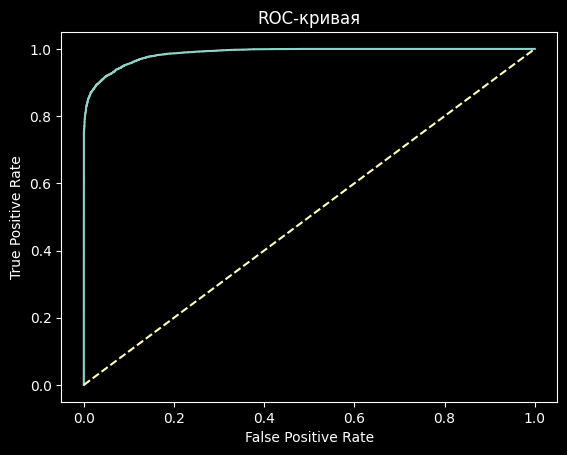

In [70]:
make_roc_curve(features_sm, target_sm, rs_rf)

По сравнению с моделью на несбалансированных данных все метрики значительно повысились.

### Обобщение метрик

In [76]:
report = pd.DataFrame(columns=model_list, data=[f1_list, auc_roc_list]).reset_index()
report.loc[0, 'index']='f1'
report.loc[1, 'index']='auc_roc'
report.set_index('index', inplace=True)

report.T

index,f1,auc_roc
Logistic Regression Unbalanced,0.322936,0.760304
Decision Tree Unbalanced,0.533123,0.672959
Random Forest Unbalanced,0.525452,0.815994
Logistic Regression Balanced,0.477586,0.765209
Decision Tree Balanced,0.847892,0.974487
Random Forest Balanced,0.866031,0.987257


Метрика F1 после балансировки данных у всех моделей повысились.

### Вывод по разделу

1. Для модели логистической регрессии наилучший результат показала модель с балансировкой данных через присвоение большего веса меньшему по численности классу.
2. У модели решающего дерева и случайного леса для балансировки данных была использована функция SMOTE. После этого оптимальные параметры подбирались в RandomizedSearchCV. Наилучшие метрики после балансировки данных показала модель случайного леса, ее мы будем использовать на тестировании.
3. После проведения балансировки данных метрики всех моделей значительно повысились по сравнению с моделями, обученными на несбалансированных данных.

## Тестирование модели

На предыдущем этапе проекта мы подобрали наилучшую модель, показавшую достаточно высокие метрики F1 и AUC-ROC на сбалансированных обучающих данных. Протестируем эту модель и посмотрим на показатели.

In [73]:
print(f'F1 лучшей модели (RF) на тестовой выборке: {f1_score(target_test, rs_rf.predict(features_test_ordinal))}')

F1 лучшей модели (RF) на тестовой выборке: 0.5964391691394659


У нас получилось добиться целевого показателя F1 на тестовой выборке. Посмотрим на остальные метрики.

In [74]:
print(f'AUC-ROC лучшей модели (RF) на тестовой выборке: {auc_roc(features_test_ordinal, target_test, rs_rf)}')

AUC-ROC лучшей модели (RF) на тестовой выборке: 0.8465345227015295


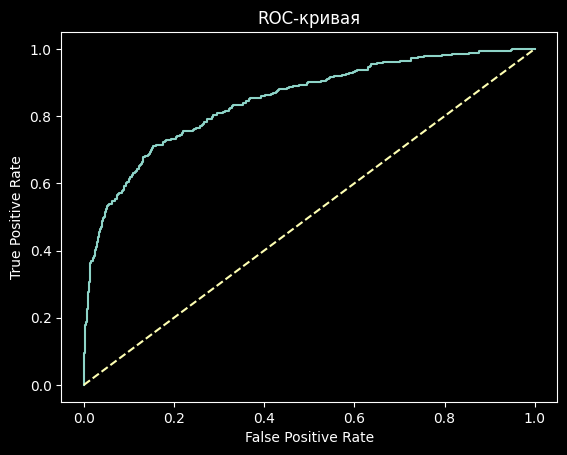

In [75]:
make_roc_curve(features_test_ordinal, target_test, rs_rf)

Как видно на ROC-кривой, предсказания нашей модели значительно отличаются от константной.

## Вывод по проекту

В этом исследовании мы попробовали решить задачу классификации на несбалансированных данных. В целевом признаке (`exited`: 1 - клиент уйдет, 0 - клиент останется) имелся дисбаланс (примерно 2 к 8).

Сначала модели логистической регрессии, решающего дерева и случайного леса были обучены на данных без учета этого дисбаланса. При этом целевого значения метрики F1 на валидационной выборке добиться не удалось.

Мы использовали несколько способов устранения дисбаланса.

1. Для модели логистической регрессии наилучший результат показала модель с балансировкой данных через присвоение большего веса меньшему по численности классу.
2. У модели решающего дерева и случайного леса для балансировки данных была использована функция SMOTE. После этого оптимальные параметры подбирались в RandomizedSearchCV. Наилучшие метрики после балансировки данных показала модель случайного леса.
3. После проведения балансировки данных метрики всех моделей значительно повысились по сравнению с моделями, обученными на несбалансированных данных.

Мы провели тестирование лучшей модели и получили значение 0.59 для метрики F1 на тестовой выборке.